# Image Derivatives
This exercise introduces image derivative operators.

In [6]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy import ndimage

## Some Convenience Functions.

In [7]:
def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def imread_gray(filename):
    """Read grayscale image."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

In [8]:
# From Question 1: Gaussian Filtering
def gauss(x, sigma):
    return 1.0 / np.sqrt(2.0 * np.pi) / sigma * np.exp(- x**2 / 2.0 / sigma**2)

## Part a
Implement a function for creating a Gaussian derivative filter in 1D according to the following equation
$$
\begin{eqnarray}
    \frac{d}{dx} G &=& \frac{d}{dx} \frac{1}{\sqrt{2\pi}\sigma} \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr) \\
			       &=& -\frac{1}{\sqrt{2\pi}\sigma^3}x \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr)
\end{eqnarray}
$$
Your function should take a vector of integer values $x$ and the standard deviation ``sigma`` as arguments.

In [9]:
def gaussdx(x, sigma):
    return - 1.0 / np.sqrt(2.0 * np.pi) / sigma**3 * x * np.exp(- x**2 / 2.0 / sigma**2)

<IPython.core.display.Javascript object>


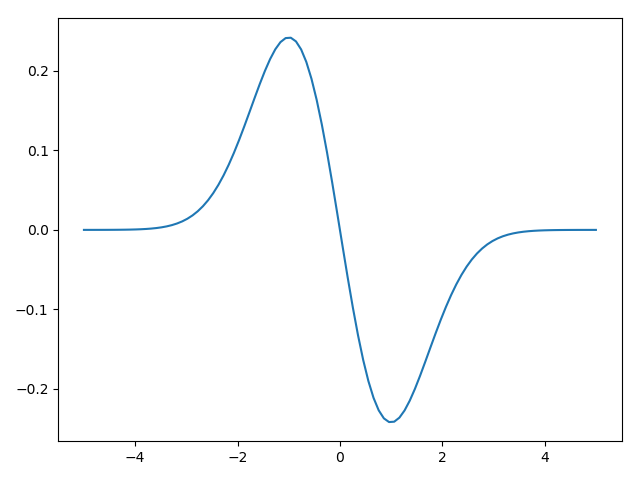

In [10]:
x = np.linspace(-5, 5, 100)
y = gaussdx(x, sigma=1.0)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

The effect of applying a filter can be studied by observing its so-called *impulse response*.
For this, create a test image in which only the central pixel has a non-zero value (called an *impulse*):

In [11]:
impulse = np.zeros((25, 25), dtype=np.float32)
impulse[12, 12] = 255

Now, create the following 1D filter kernels ``gaussian`` and ``derivative``.

In [12]:
sigma = 6.0
kernel_radius = int(3.0 * sigma)
x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
G = gauss(x, sigma)
D = gaussdx(x, sigma)

What happens when you apply the following filter combinations?

- first ``gaussian``, then ``gaussian^T``.
- first ``gaussian``, then ``derivative^T``.
- first ``derivative``, then ``gaussian^T``.
- first ``gaussian^T``, then ``derivative``.
- first ``derivative^T``, then ``gaussian``.

Display the result images with the `plot_multiple` function. Describe your result.

<IPython.core.display.Javascript object>


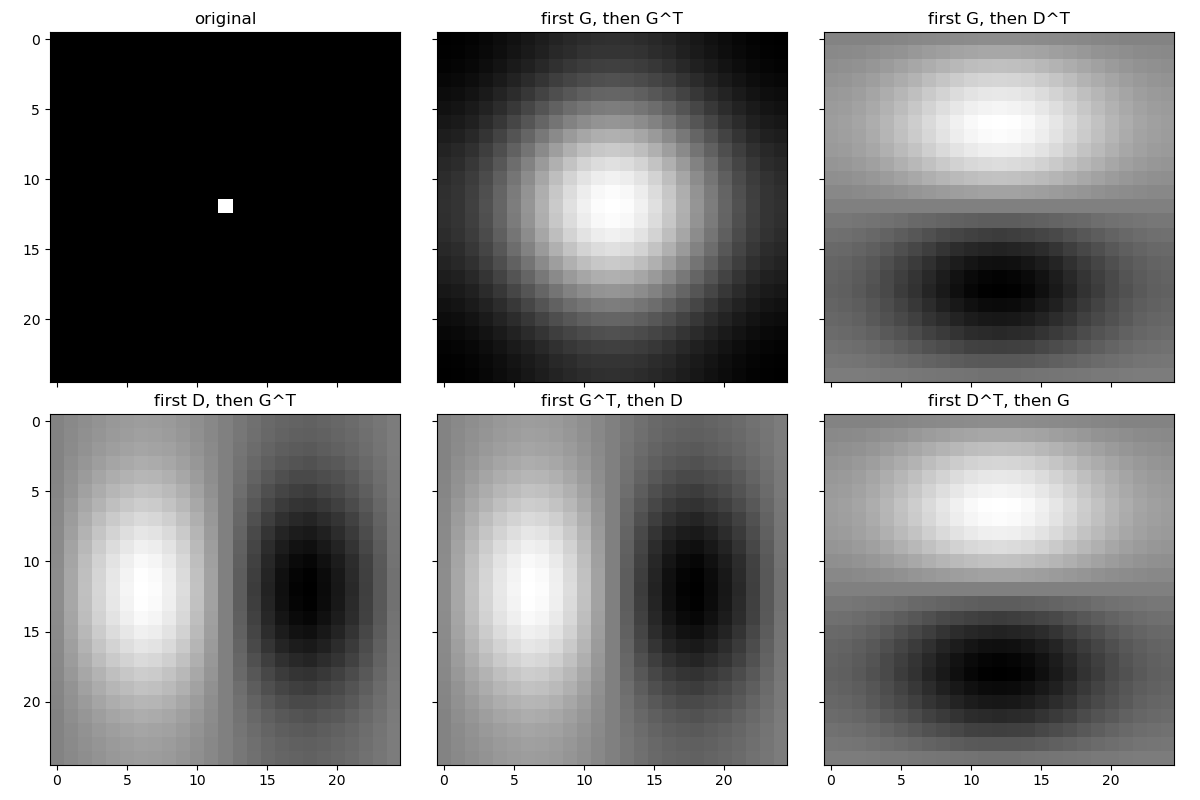

In [13]:
images = [
    impulse,
    convolve_with_two(impulse, G, G.T),
    convolve_with_two(impulse, G, D.T),
    convolve_with_two(impulse, D, G.T),
    convolve_with_two(impulse, G.T, D),
    convolve_with_two(impulse, D.T, G)]

titles = [
    'original',
    'first G, then G^T',
    'first G, then D^T',
    'first D, then G^T',
    'first G^T, then D',
    'first D^T, then G']

plot_multiple(images, titles, max_columns=3)

## Part b

Use the functions ``gauss`` and ``gaussdx`` directly in order to create a new function ``gaussderiv`` that returns the 2D Gaussian derivatives of an input image in $x$ and $y$ direction.

In [14]:
def gauss_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    
    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    
    image_dx = convolve_with_two(image, D, G.T)
    image_dy = convolve_with_two(image, G, D.T)
    return image_dx, image_dy

Try the function on the given example images and describe your results.

<IPython.core.display.Javascript object>


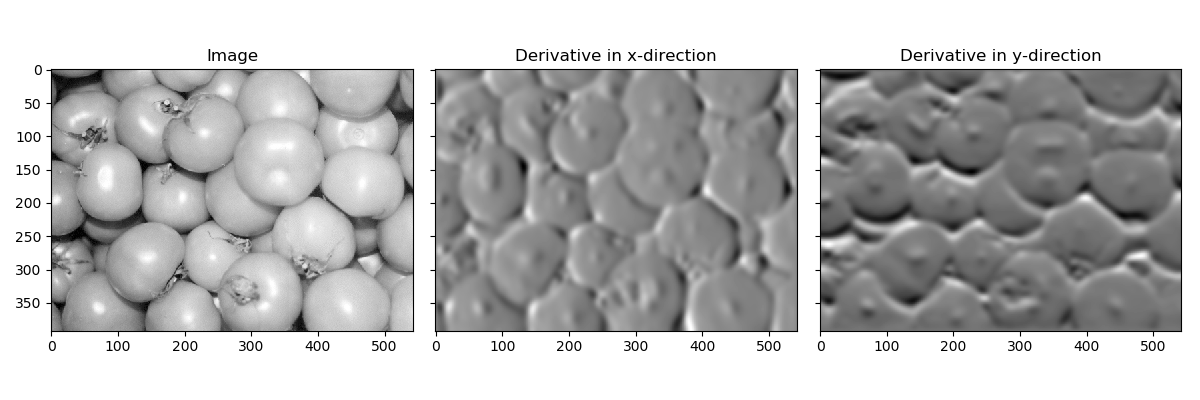

In [15]:
image = imread_gray('tomatoes.png')
grad_dx, grad_dy = gauss_derivs(image, sigma=5.0)
plot_multiple([image, grad_dx, grad_dy], ['Image', 'Derivative in x-direction', 'Derivative in y-direction'])

In a similar manner, create a new function ``gauss_second_derivs`` that returns the 2D second Gaussian derivatives $\frac{d^2}{dx^2}$, $\frac{d^2}{dx dy}$ and $\frac{d^2}{dy^2}$ of an input image.

In [16]:
def gauss_second_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    
    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    
    image_dx, image_dy = gauss_derivs(image, sigma)
    
    image_dxx = convolve_with_two(image_dx, D, G.T)
    image_dyy = convolve_with_two(image_dy, G, D.T)
    image_dxy = convolve_with_two(image_dx, G, D.T)
    
    return image_dxx, image_dxy, image_dyy

Try the function on the given example images and describe your results.

<IPython.core.display.Javascript object>


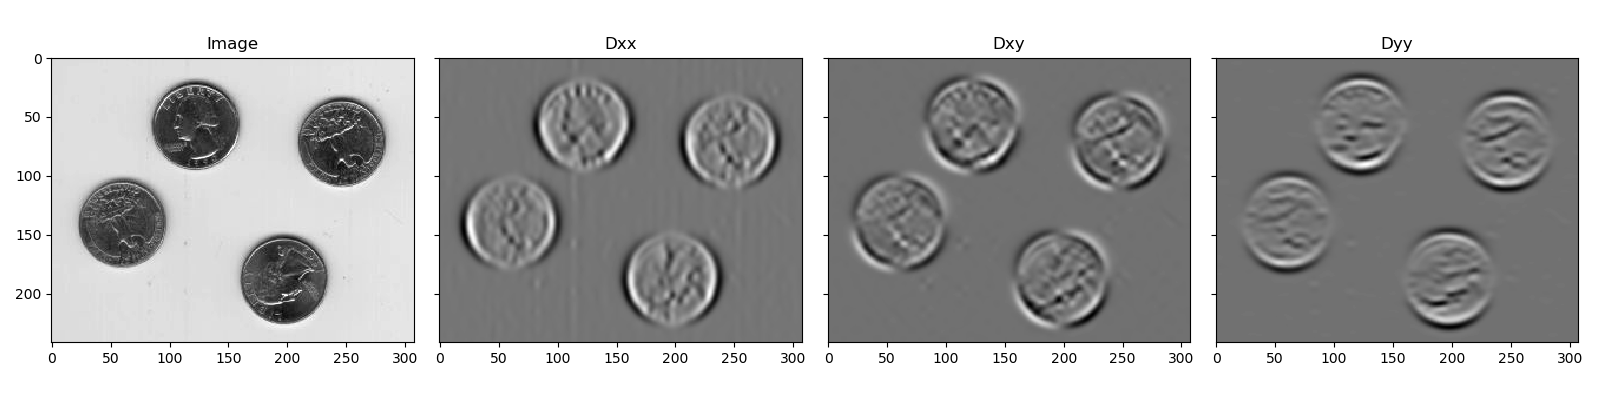

In [17]:
image = imread_gray('coins1.jpg')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ['Image', 'Dxx', 'Dxy','Dyy'])

<IPython.core.display.Javascript object>


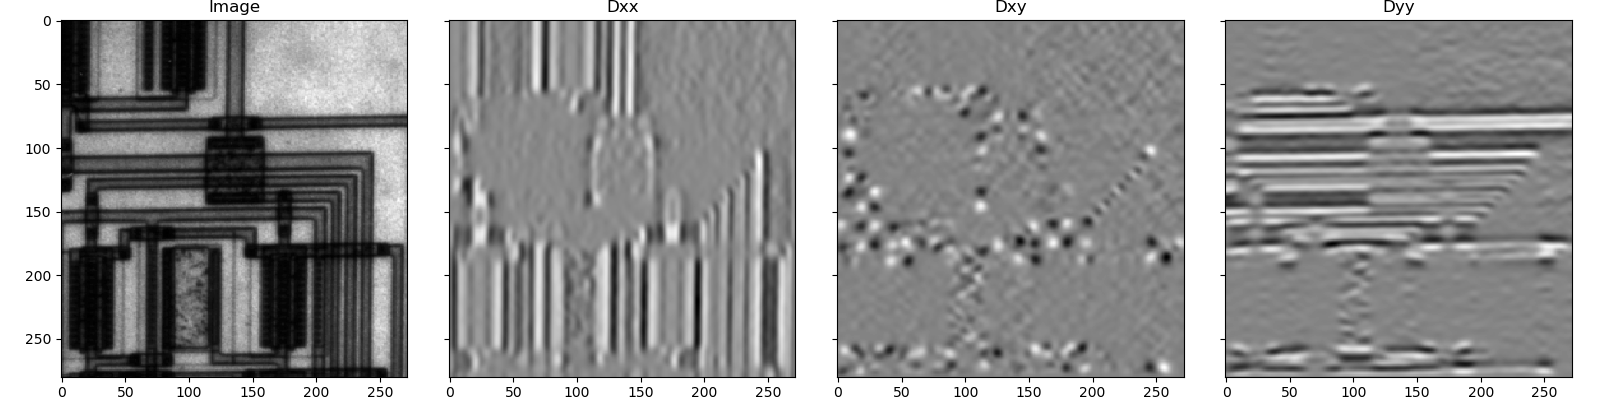

In [23]:
image = imread_gray('circuit.png')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ['Image', 'Dxx', 'Dxy','Dyy'])

## Part c
Create a new function ``image_gradients_polar`` that returns two images with the magnitude and orientation of the gradient for each pixel of the input image.

In [18]:
def image_gradients_polar(image, sigma):
    grad_dx, grad_dy = gauss_derivs(image, sigma)
    magnitude = np.sqrt(grad_dx**2.0 + grad_dy**2.0)
    direction = np.arctan2(grad_dy, grad_dx)
    return magnitude, direction

Try the function on the given example images and describe your results.

<IPython.core.display.Javascript object>


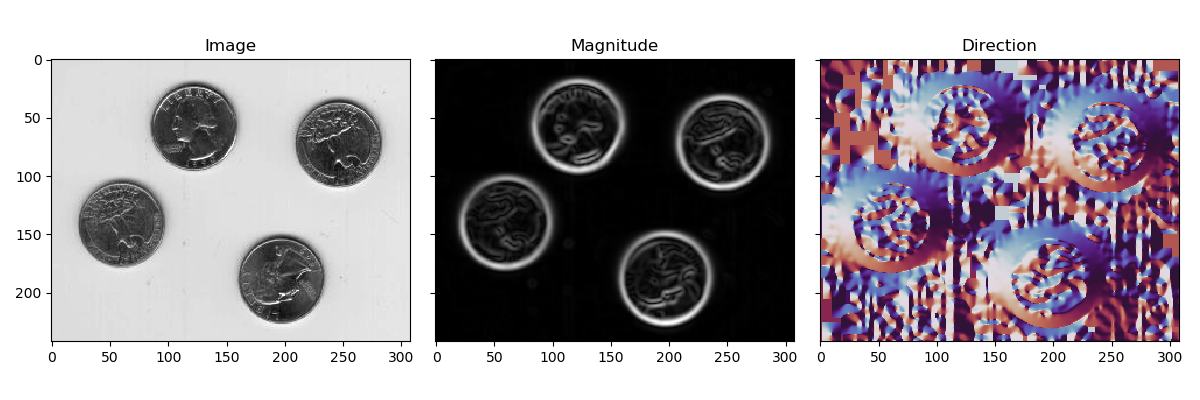

In [19]:
image = imread_gray('coins1.jpg')
grad_mag, grad_dir = image_gradients_polar(image, sigma=2.0)

# Note: the twilight colormap only works since Matplotlib 3.0, use 'gray' in earlier versions.
plot_multiple([image, grad_mag, grad_dir], ['Image', 'Magnitude', 'Direction'], colormap=['gray', 'gray', 'twilight']) 

<IPython.core.display.Javascript object>


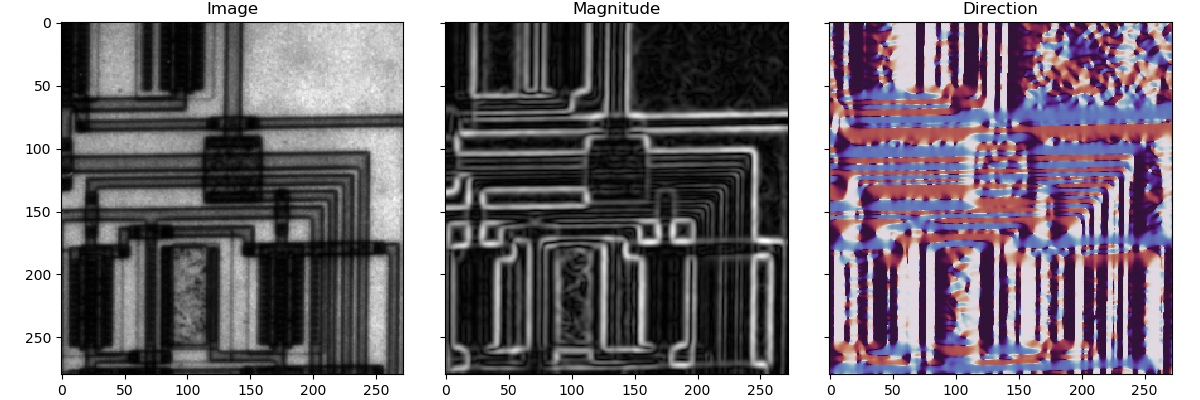

In [24]:
image = imread_gray('circuit.png')
grad_mag, grad_theta = image_gradients_polar(image, sigma=2.0)
plot_multiple([image, grad_mag, grad_theta], ['Image', 'Magnitude', 'Direction'], colormap=['gray', 'gray', 'twilight'])

## Part d
Create a new function ``laplace`` that returns an image with the Laplacian-of-Gaussian for each pixel of the input image.

In [20]:
def laplace(image, sigma):
    grad_dxx, _, grad_dyy = gauss_second_derivs(image, sigma)
    return grad_dxx + grad_dyy

Try the function on the given example images and describe your results.

<IPython.core.display.Javascript object>


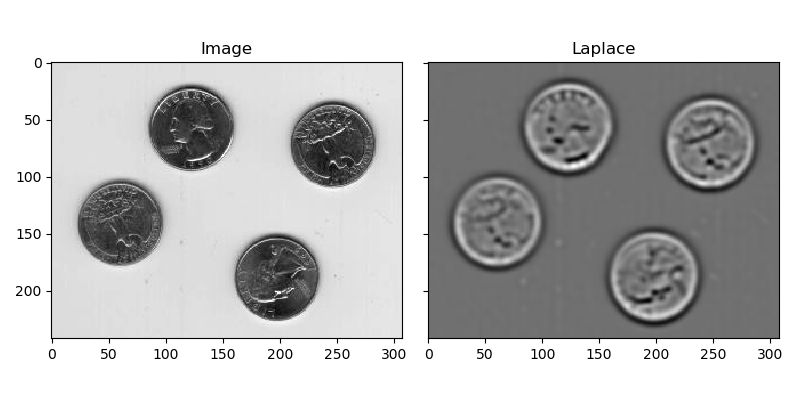

In [21]:
image = imread_gray('coins1.jpg')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

<IPython.core.display.Javascript object>


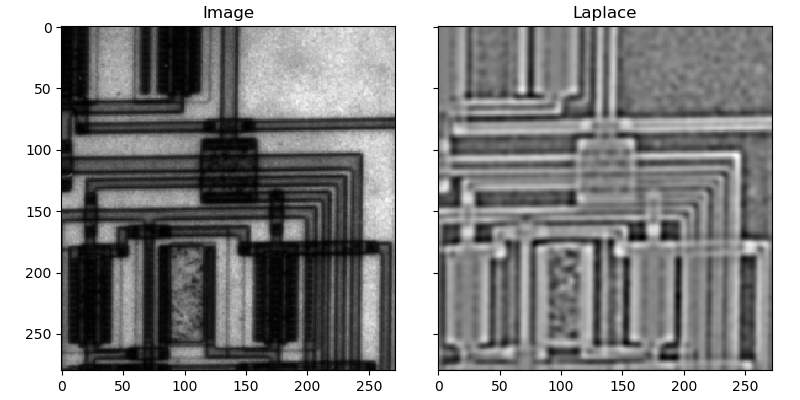

In [22]:
image = imread_gray('circuit.png')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])